## Application of BPR on Zazzle Data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
from subprocess import call
from pybpr import *
import scipy.sparse as sp
from functools import reduce
import matplotlib.pyplot as plt
from functools import partial

In [4]:
DATA_DIR = '/projects/zazzle/rsandhu/pybpr/examples/output/zazzle_data'

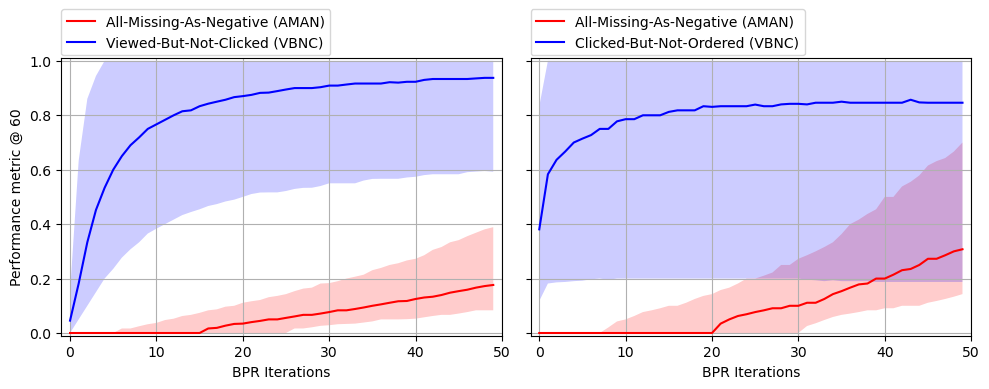

In [12]:
#uniform_viewed = np.loadtxt(os.path.join(DATA_DIR, 'run2_pos_viewed.txt'))
uniform_clicked = np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_clicked.txt'))
uniform_ordered = np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_ordered.txt'))
explicit_clicked= np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_clicked_neg_viewed_not_clicked.txt'))
explicit_ordered = np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_ordered_neg_clicked_not_ordered.txt'))

def plot_this(iax, idata, clr, lbl=None):
    iax.plot(idata[:,1], color=clr, label=lbl)
    xgrid = np.arange(0,idata.shape[0])
    iax.fill_between(xgrid, idata[:,0], idata[:,2], color=clr, alpha=0.2, ec=None)
    iax.grid(True)
    iax.set_xlabel('BPR Iterations')

fig, ax = plt.subplots(1,2,figsize=(10,4.), sharey=True)
plot_this(ax[0], uniform_clicked, 'r', 'All-Missing-As-Negative (AMAN)')
plot_this(ax[0], explicit_clicked, 'b', 'Viewed-But-Not-Clicked (VBNC)')
plot_this(ax[1], uniform_ordered, 'r', 'All-Missing-As-Negative (AMAN)')
plot_this(ax[1], explicit_ordered, 'b', 'Clicked-But-Not-Ordered (VBNC)')

for iax in ax:
    iax.set_ylim([-0.01,1.01])
    iax.set_xlim([-1,50])
    iax.legend(loc=(0,1.01), borderaxespad=0)
ax[0].set_ylabel('Performance metric @ 60')
fig.tight_layout()

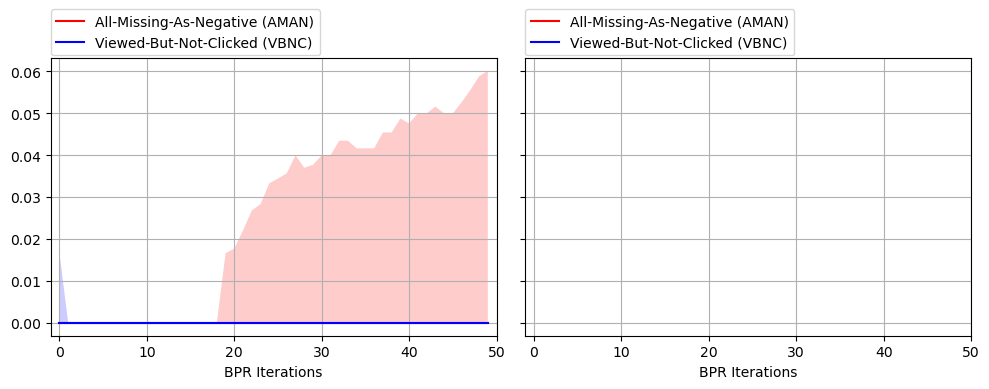

In [11]:
#uniform_viewed = np.loadtxt(os.path.join(DATA_DIR, 'run2_pos_viewed.txt'))
uniform_clicked = np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_clicked_test.txt'))
uniform_ordered = np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_ordered_test.txt'))
explicit_clicked= np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_clicked_neg_viewed_not_clicked_test.txt'))
explicit_ordered = np.loadtxt(os.path.join(DATA_DIR, 'run3_pos_ordered_neg_clicked_not_ordered_test.txt'))

def plot_this(iax, idata, clr, lbl=None):
    iax.plot(idata[:,1], color=clr, label=lbl)
    xgrid = np.arange(0,idata.shape[0])
    iax.fill_between(xgrid, idata[:,0], idata[:,2], color=clr, alpha=0.2, ec=None)
    iax.grid(True)
    iax.set_xlabel('BPR Iterations')

fig, ax = plt.subplots(1,2,figsize=(10,4.), sharey=True)
plot_this(ax[0], uniform_clicked, 'r', 'All-Missing-As-Negative (AMAN)')
plot_this(ax[0], explicit_clicked, 'b', 'Viewed-But-Not-Clicked (VBNC)')
plot_this(ax[1], uniform_ordered, 'r', 'All-Missing-As-Negative (AMAN)')
plot_this(ax[1], explicit_ordered, 'b', 'Viewed-But-Not-Clicked (VBNC)')

for iax in ax:
    #iax.set_ylim([-0.01,1.01])
    iax.set_xlim([-1,50])
    iax.legend(loc=(0,1.01), borderaxespad=0)
fig.tight_layout()

## Put Zazzle data in UserItemInteration Class object

In [4]:
DATA_DIR = '/projects/zazzle/rsandhu/pybpr/examples/output/zazzle_data'
vdf = pd.read_parquet(os.path.join(DATA_DIR, 'view_data.parquet'))
cdf = pd.read_parquet(os.path.join(DATA_DIR, 'click_data.parquet'))
odf = pd.read_parquet(os.path.join(DATA_DIR, 'order_data.parquet'))

In [ ]:
%%time
num_users = vdf['user_idx'].max()+1
num_items = vdf['product_idx'].max()+1
view_data = UserItemInteractions(
    name='ZAZZLE VIEW DATA',
    users_index=vdf['user_idx'],
    items_index=vdf['product_idx']
)
view_data.generate_train_test(user_test_ratio=0.0)

In [ ]:
%%time
click_data = UserItemInteractions(
    name='ZAZZLE CLICK DATA',
    users_index=cdf['user_idx'],
    items_index=cdf['product_idx'],
    num_users = num_users,
    num_items = num_items
)
click_data.generate_train_test(user_test_ratio=0.0)

In [ ]:
%%time
order_data = UserItemInteractions(
    name='ZAZZLE ORDER DATA',
    users_index=odf['user_idx'],
    items_index=odf['product_idx'],
    num_users = num_users,
    num_items = num_items
)
order_data.generate_train_test(user_test_ratio=0.0)

In [ ]:
vdf.merge(cdf)

In [ ]:
cdf.shape, odf.shape, vdf.shape

In [ ]:
idf = vdf.merge(cdf, on=['user_id','product_id'], how='left', indicator=True)
ibool = idf['_merge']=='left_only'

In [ ]:
df_viewed_but_not_clicked = vdf[ibool.values]

In [ ]:
df_viewed_but_not_clicked

## BPR 

In [ ]:
bpr1 = BPR(
    num_features=50,
    reg_lambda=0.0,
    num_iters=50,
    learning_rate = 0.02,
    batch_size=10000,
    initial_std=0.0001,
)
bpr1.initiate(num_users=view_data.num_users, num_items=view_data.num_items)

In [ ]:
training_data = click_data.mat_train
metric_log_train = []
neg_sampler = partial(
    uniform_negative_sampler, 
    uimat=training_data
)
for _ in range(100):
    results = bpr_fit(
        bpr_obj=bpr1, 
        neg_sampler=neg_sampler, 
        ncores=104
    )
    mfunc = partial(
        bpr1.get_metric_v1,
        perc_active_users=0.5,
        perc_active_items=0.5,
        num_recs=60
    )
    metric_log_train.append(mfunc(uimat=training_data))
metric_log_train = np.asarray(metric_log_train)

In [ ]:
idata = np.loadtxt(os.path.join(DATA_DIR, 'run_view.txt'))

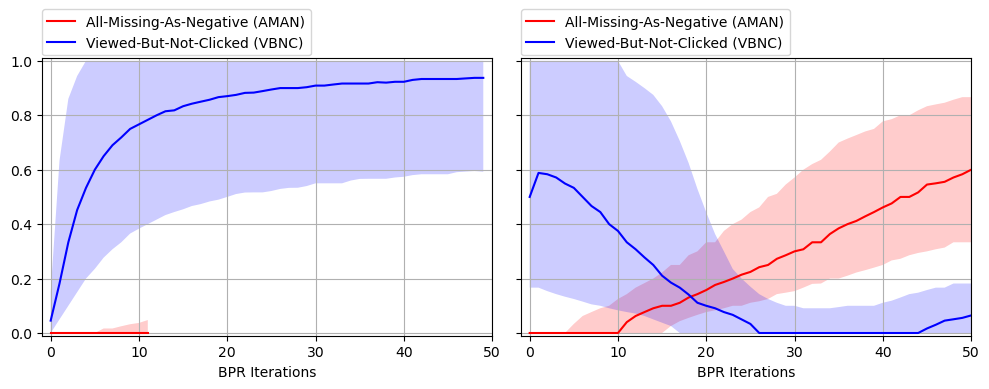

In [ ]:
idata_uniform = np.loadtxt(os.path.join(DATA_DIR, 'run_pos_clicked.txt'))
idata_explicit = np.loadtxt(os.path.join(DATA_DIR, 'run_pos_clicked_neg_viewed_not_clicked.txt'))

# idata_uniform = np.loadtxt(os.path.join(DATA_DIR, 'run_pos_ordered.txt'))
# idata_explicit = np.loadtxt(os.path.join(DATA_DIR, 'run_pos_ordered_neg_clicked_not_ordered.txt'))


xgrid = np.arange(0,idata.shape[0])
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(idata_uniform[:,1], '-b')
ax.fill_between(xgrid, idata_uniform[:,0], idata_uniform[:,2], color='b', alpha=0.2, ec=None)
ax.plot(idata_explicit[:,1], '-r')
ax.fill_between(xgrid, idata_explicit[:,0], idata_explicit[:,2], color='r', alpha=0.2, ec=None)

ax.set_ylabel('Performance Metric (Training)')

In [ ]:
%%time
metric1 = order_data.get_metric_v1(
    umat=bpr1.umat, 
    imat=bpr1.imat, 
    perc_active_users=0.25, 
    perc_active_items=0.25,
    num_recs=60
)

In [ ]:
interaction_count = np.array([20, 30, 40])
recs_count = np.array([60,60,60])
nonoverlap_count = np.array([70, 70, 70])
np.divide(
    interaction_count + recs_count - nonoverlap_count,
    interaction_count,
    out=np.zeros_like(interaction_count, dtype=float),
    where=interaction_count != 0
)

In [ ]:
order_data.mat

In [ ]:
(xx + order_data.mat).count_nonzero()

In [ ]:
xx.nnz + order_data.mat.nnz - (xx + order_data.mat).count_nonzero()

In [ ]:
active_users = order_data.users_sorted_by_activity()

In [ ]:
umat_sliced = bpr1.umat.take(active_users, axis=0)
rec_mat = umat_sliced.dot(bpr1.imat.T)

In [ ]:
np.amax(rec_mat)

In [ ]:
np.argsort(rec_mat)

In [ ]:
# computes the performance metric
click_data.get_zazzle_metric_v1(umat=bpr1.umat, imat=bpr1.imat, user_count=2000, num_recs=60)

In [ ]:
rec_items = order_data.get_top_items_for_this_user(30, user_mat=bpr1.umat, item_mat=bpr1.imat, num_items=60, exclude_liked=True)

In [ ]:
bpr1.umat.shape

In [ ]:
2000*5000

In [ ]:
view_data.mat_train.nnz

In [ ]:
(2000*50000)/(16414*736254 - view_data.mat.nnz)

In [ ]:
view_data.mat.nnz

In [ ]:
xx = []
for i in range(10):
    xx.append(i)

In [ ]:
xx

In [ ]:
test1 = UserItemInteractions(
    users_index=np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4,
                          5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8])-1,
    items_index=np.array([1, 2, 3, 4, 5, 1, 2, 3, 4, 2, 3, 4, 5, 2, 3, 4,
                          6, 7, 8, 9, 10, 6, 7, 8, 9, 7, 8, 9, 10, 7, 8, 9])-1,
    num_items=10,
    num_users=8
)

In [ ]:
test1.mat.toarray()

In [ ]:
bpr1 = BPR(
    num_features=2,
    reg_lambda=0.0001,
    num_iters=200,
    learning_rate = 0.2,
    batch_size=50,
    initial_std=0.01,
)
bpr1.initiate(uimat=test1.mat)

In [ ]:
bpr_fit(bpr_obj=bpr1, iumat=test1.mat, ncores=1)

In [ ]:
test1.get_metric_v1(
    umat=bpr1.umat,
    imat=bpr1.imat,
    perc_active_users=1.0,
    perc_active_items=1.0,
    num_recs=5
)

In [ ]:
np.around(bpr1.imat,2)

In [ ]:
xmat = bpr1.umat.dot(bpr1.imat.T)

In [ ]:
np.around(xmat,1)

In [ ]:
xmat = xmat > 0.5

In [ ]:
xmat.astype(int)

In [ ]:
# how to fast sort this matrix
# rewrite bpr_* functions into class and try parralel pool to see if it works

In [ ]:
np.random.seed(123)
#xx = np.random.choice(int(1e8), size=int(1e8))
xx = np.random.randn(10, int(1e5))

In [ ]:
xx

In [ ]:
#%%timeit
yy1 = np.argsort(xx, axis=1)[:, ::-1]

In [ ]:
data = np.asarray(order_data.mat.sum(axis=1)).reshape(-1)
count, bins_count = np.histogram(data, bins=100, range=(0,200)) 
pdf = count / sum(count) 
cdf = np.cumsum(pdf) 
plt.plot(bins_count[1:], cdf,  '-r', label="Order") 
plt.xlim([0,100])

data = np.asarray(click_data.mat.sum(axis=1)).reshape(-1)
count, bins_count = np.histogram(data, bins=200, range=(0,200)) 
pdf = count / sum(count) 
cdf = np.cumsum(pdf) 
plt.plot(bins_count[1:], cdf,  '-b', label="Click") 
plt.legend()
plt.grid(True)

In [ ]:
#%%timeit
yy2 = np.argpartition(xx, kth=xx.shape[1]-60, axis=1)[:,::-1][:,:60]
yy2.shape

In [ ]:
yy2[1,:]

In [ ]:
np.ravel(yy2)[58:62]

In [ ]:
yy2[0, :60]

In [ ]:
xxx = np.array([[1,2,3,-1,0,6,7,-4,-2],[10,20,30,-10,0,60,70,-40,-20]])
np.argsort(xxx, axis=1)[::-1]

In [ ]:
np.argpartition(xxx, 6)[::-1]